In [1]:
import os
from models.BYOL2_model import BYOL2
from models.sbir_byol import SBIR_BYOL
from data.custom_transforms import PadToSquare
from skimage.io import imread, imsave, imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
import torch
from torchvision.datasets import ImageFolder
import torchvision.models as models

import torchvision.transforms as T

from PIL import ImageFont, Image, ImageDraw

device = 'cuda:1'

In [2]:
shoes = {"queries" : 'bimodal_byol_shoes_utils/Shoes/sketches_test/',
         "catalogue" : 'bimodal_byol_shoes_utils/Shoes/images_test/',
         "red": 'bimodal_byol_shoes_utils/checkpoints/self_bimodal_byol_sketchy_then_shoes_5epochs.pt'}

ecommerce = {"queries" : '/users/btorres/database/ecommerce/sketches_valid/',
             "catalogue" : '/users/btorres/database/ecommerce/images/valid/',
             "red" : 'bimodal_byol_shoes_utils/checkpoints/sketchy/self_bimodal_byol_ecommerce_liquifyOnline90_randomMovement50_batch105_2epochs.pt' }

test_color = {  "queries" : '/users/btorres/database/sketches_jpg/',
                "catalogue" : '/users/btorres/database/ColorSketchDatasetTest/',
              "red" : 'bimodal_byol_shoes_utils/checkpoints/Color/pretrained_ecommerce_bestSketch_filtros_segment_1epoch.pt' }

test_sketches = { "queries" : '/users/btorres/database/ImageData/photos/',
                  "catalogue" : '/users/btorres/database/ImageData/sketches',
                  "red" : 'bimodal_byol_shoes_utils/checkpoints/Color/pretrained_ecommerce_bestSketch_filtros_segment_1epoch.pt' }


Datos = test_sketches.copy()

In [13]:
def get_rank( idx, queries_embeddings, queries, catalogue_embeddings, catalogue):
    q_embeddings = queries_embeddings.numpy()
    c_embeddings = catalogue_embeddings.numpy()

    queries_names = queries.imgs
    catalogue_names = catalogue.imgs

    query_path = queries_names[idx][0]
    query_name = os.path.basename(query_path).split("_")[-3]


    distances = np.sqrt(np.sum(np.square(c_embeddings - q_embeddings[idx]), 1))
    indices = np.argsort(distances)

    r = 1
    rank = -1
    for j in indices:

        catalogue_path = catalogue_names[j][0]
        catalogue_name = os.path.basename(catalogue_path).split(".")[0]

        if query_name == catalogue_name:
            rank = 1/r
            break

        r = r + 1

    return rank

def get_catalogue_img_index(idx, queries, catalogue):

    queries_names = queries.imgs
    catalogue_names = catalogue.imgs

    query_path = queries_names[idx][0]
    query_name = os.path.basename(query_path).split("_")[-3]


    rel = -1
    for count, (catalogue_path, index) in enumerate(catalogue_names):
        catalogue_name = os.path.basename(catalogue_path).split(".")[0]

        if catalogue_name == query_name:
            rel = count
    return rel

def text_on_image(size=(224,224), texto="", tam = 90, pos=(30,60)):

    img = Image.new('RGB', size, color = (255, 255, 255))
    d = ImageDraw.Draw(img)

    font = ImageFont.truetype("/users/btorres/redesNeuronales/library/font/arial.ttf", tam)
    d.text(pos, texto, font=font, fill=(0,0,0))

    return np.asarray(img)

def get_embeddings_labels(model, dataloader, mode):
    model.eval()
    embeddings = []
    labels = []
    for i, (batch, label) in enumerate(dataloader):
        batch = batch.to(device, dtype=torch.float)
        with torch.no_grad():
            current_projection, current_embedding = model(batch, return_embedding=mode)
        embeddings.append(current_embedding.to('cpu'))
        labels.append(label)
        sys.stdout.write('\rBatch {} done.'.format(i))
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0).numpy()



def frame_image(img, frame_width, value=(0,0,0)):
    b = frame_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((b+ny+b, b+nx+b))*value[0],
        np.ones((b+ny+b, b+nx+b))*value[1],
        np.ones((b+ny+b, b+nx+b))*value[2]
    ])
    framed_img = framed_img.transpose(1,2,0).astype(np.uint8)
    framed_img[b:-b, b:-b] = img
    return framed_img

def right_border_image(img, border_width, value=(0,0,0)):
    b = border_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((ny, nx+b))*value[0],
        np.ones((ny, nx+b))*value[1],
        np.ones((ny, nx+b))*value[2]
    ])
    framed_img = framed_img.transpose(1,2,0).astype(np.uint8)
    framed_img[:,:-b] = img
    return framed_img

def plot_best_10_multiple(queries, queries_embeddings, queries_labels, catalogue, catalogue_embeddings, catalogue_labels, selected_indices, discard_first=False, lines_width=8):

    q_embeddings = queries_embeddings.numpy()
    c_embeddings = catalogue_embeddings.numpy()
    
    fig, axes = plt.subplots(nrows=len(selected_indices) + 1, ncols=13, figsize=(int(13*1.5), int(len(selected_indices)*1.5)))

    img_text = text_on_image(texto="original", tam=56)

    axes[0][0].imshow(img_text.astype(np.uint8))
    axes[0][0].axis('off')

    img_text = text_on_image(texto="dibujo", tam=56)

    axes[0][1].imshow(img_text.astype(np.uint8))
    axes[0][1].axis('off')

    img_text = text_on_image(texto="rango", tam=56)

    img_text = right_border_image( img_text.astype(np.uint8),lines_width)

    axes[0][2].imshow(img_text.astype(np.uint8))
    axes[0][2].axis('off')

    for k in range(3, 13):
        img_text = text_on_image(texto="", tam=55)

        axes[0][k].imshow(img_text.astype(np.uint8))
        axes[0][k].axis('off')



    
    for i, selected_idx in enumerate(selected_indices):
        i = i+1

        distances = np.sqrt(np.sum(np.square(c_embeddings - q_embeddings[selected_idx]), 1))
        indices = np.argsort(distances)

        #catalogue_index = get_catalogue_img_index(selected_idx, queries, catalogue)


        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[0:10]
        best = []
        best_labels = []
        for idx in best_indices:
            best.append(catalogue[idx])
            best_labels.append(catalogue_labels[idx])

        selected = queries[selected_idx][0].numpy().transpose(1,2,0)
        selected_label = queries_labels[selected_idx]
        #selected = right_border_image(selected,lines_width)

        #catalogue_img = catalogue[catalogue_index][0].numpy().transpose(1,2,0)
        #catalogue_img = right_border_image(catalogue_img,lines_width)


        #axes[i][0].imshow(catalogue_img.reshape(224,224, 3).astype(np.uint8))
        #axes[i][0].axis('off')


        axes[i][1].imshow(selected.reshape(224,224, 3).astype(np.uint8))
        axes[i][1].axis('off')
        #axes[i][2].axis('off')

        #rank = str(get_rank(selected_idx, queries_embeddings, queries, catalogue_embeddings, catalogue))[0:5]

        #rango = text_on_image(texto=rank, tam=70)

        #rango = right_border_image( rango.astype(np.uint8),lines_width)

        #axes[i][2].imshow(rango)
        #axes[i][2].axis('off')


        for j, (image, label) in enumerate(best):
            image = image.numpy().transpose(1,2,0)
            #if selected_label != best_labels[j]:
            #    image =  frame_image(image.reshape(224,224, 3), lines_width, (255,0,0))
            #    axes[i][j+2].imshow(image.reshape(224+lines_width*2,224+lines_width*2,3))
            #else:
            axes[i][j+3].imshow(image.reshape(224,224,3).astype(np.uint8))
            axes[i][j+3].axis('off')
    return fig, axes

In [14]:
#Transformaciones para las imágenes
transform_queries = T.Compose([
    PadToSquare(fill=255),
    T.Resize((224,224)),
    T.PILToTensor()
])

transform_catalogue = T.Compose([
    PadToSquare(fill=255),
    T.Resize((224,224)),
    T.PILToTensor()
])

#Cargar archivos
queries = ImageFolder(
    root = Datos["queries"],
    transform = transform_queries)

catalogue = ImageFolder(
    root = Datos["catalogue"],
    transform = transform_catalogue)


queries_loader = torch.utils.data.DataLoader(queries, batch_size=50, shuffle=False)
catalogue_loader = torch.utils.data.DataLoader(catalogue, batch_size=50, shuffle=False)

#encoder = models.resnet.ResNet( models.resnet.Bottleneck, [3,4,6,0])
encoder = models.resnet50()
#encoder.layer4 = encoder.layer4[0:1]

learner = BYOL2(
    encoder,
    image_size=224,
    hidden_layer='avgpool',
    #use_momentum=False
)

#learner = SBIR_BYOL(
#    encoder,
#    image_size=224,
#    hidden_layer='avgpool'
#)

# red color
learner.load_state_dict(torch.load(Datos["red"], map_location=torch.device(device)))

learner = learner.to(device)


In [15]:
queries_embeddings, queries_labels = get_embeddings_labels(learner, queries_loader, 'target')

Batch 11 done.

In [16]:
catalogue_embeddings, catalogue_labels = get_embeddings_labels(learner, catalogue_loader, 'online')

Batch 20 done.

(<Figure size 1368x864 with 117 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       

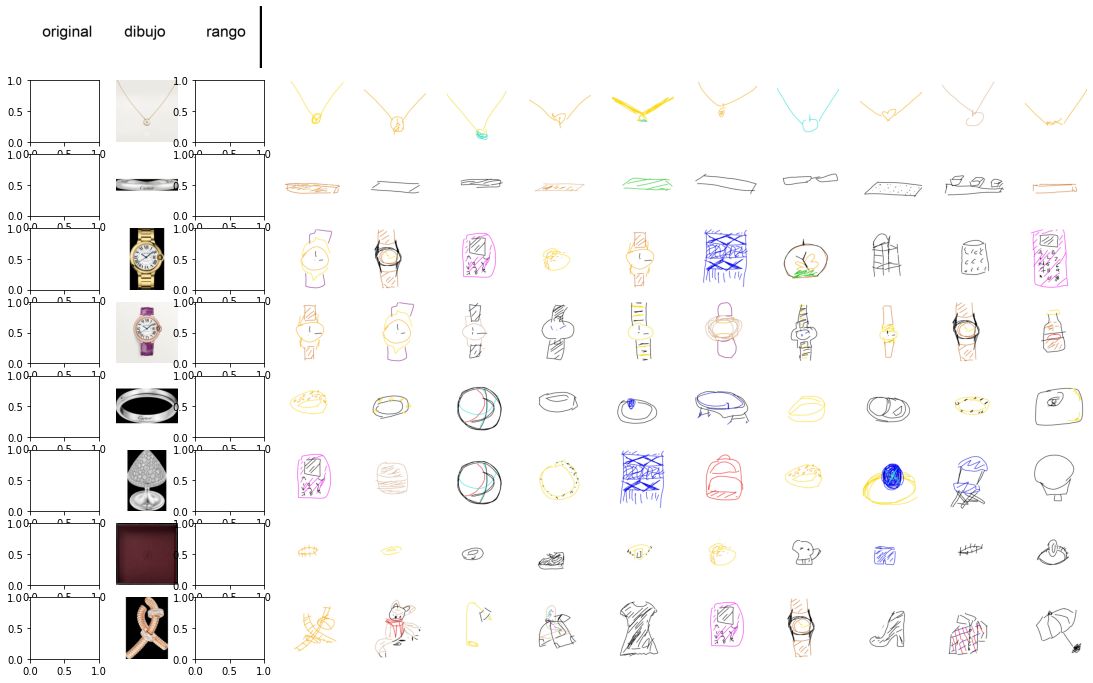

In [17]:
#indices_imagenes = np.array(list(range(50)))
indices_imagenes = [ 1, 3 ,7, 8, 14, 15, 21, 40]
plot_best_10_multiple(queries, queries_embeddings, queries_labels, catalogue, catalogue_embeddings, catalogue_labels, indices_imagenes)



In [14]:
def get_AP(idx, queries_embeddings, queries, catalogue_embeddings, catalogue):

    q_embeddings = queries_embeddings.numpy()
    c_embeddings = catalogue_embeddings.numpy()

    queries_names = queries.imgs
    catalogue_names = catalogue.imgs

    query_path = queries_names[idx][0]
    query_class = query_path.split("/")[-2]


    distances = np.sqrt(np.sum(np.square(c_embeddings - q_embeddings[idx]), 1))
    indices = np.argsort(distances)

    AP = np.array([])
    GTP = 0
    TPseen = 1
    r = 1

    for j in indices:

        catalogue_path = catalogue_names[j][0]
        catalogue_class = catalogue_path.split("/")[-2]

        if query_class == catalogue_class:
            ap = TPseen/r
            AP = np.append(AP, ap)

            TPseen += 1
            GTP += 1

        r += 1

    return np.sum(AP)/GTP


def get_rank( idx, queries_embeddings, queries, catalogue_embeddings, catalogue):
    q_embeddings = queries_embeddings.numpy()
    c_embeddings = catalogue_embeddings.numpy()

    queries_names = queries.imgs
    catalogue_names = catalogue.imgs

    query_path = queries_names[idx][0]
    query_name = os.path.basename(query_path).split("_")[-3]


    distances = np.sqrt(np.sum(np.square(c_embeddings - q_embeddings[idx]), 1))
    indices = np.argsort(distances)

    r = 1
    rank = -1
    for j in indices:

        catalogue_path = catalogue_names[j][0]
        catalogue_name = os.path.basename(catalogue_path).split(".")[0]

        if query_name == catalogue_name:
            rank = 1/r
            break

        r = r + 1

    return rank


# métricas color

q_embeddings = queries_embeddings.numpy()

rank = np.array([])
mAP = np.array([])

for idx in range(queries_embeddings.shape[0]):
    r = get_rank(idx, queries_embeddings, queries, catalogue_embeddings, catalogue)
    AP = get_AP(idx, queries_embeddings, queries, catalogue_embeddings, catalogue)

    sys.stdout.write('\r {} de {} imágenes procesadas'.format(idx + 1, queries_embeddings.shape[0]))

    if r == -1:
        continue
    else:
        rank = np.append(rank, r)
    mAP = np.append(mAP, AP)

print("\n")
print("mAP: ", np.mean(mAP))
print("MRR: ", np.mean(rank))

 444 de 444 imágenes procesadas

mAP:  0.09274039030864882
MRR:  0.14616035081290127


In [20]:
filename = "/users/btorres/databases/ecommerce/images/valid/images_color_list.txt"

with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

name_clase = {}

for l in lines:
    a = l.split("\t")
    name_clase[a[0].split("/")[-1]] = a[1]


filename = "/users/btorres/databases/ecommerce/sketches_valid/sk_classification.txt"

with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

archivosClases = {}
for line in lines:
    archivosClases[line.split("\t")[0].split("/")[-1]] = line.split("\t")[-1]

archivosClases['221 - copia.PNG'] = archivosClases['221.PNG']


print(archivosClases)


{'1.PNG': '0', '2.PNG': '0', '3.PNG': '0', '4.PNG': '0', '5.PNG': '0', '6.PNG': '1', '7.PNG': '1', '8.PNG': '1', '9.PNG': '1', '10.PNG': '1', '11.PNG': '2', '12.PNG': '2', '13.PNG': '2', '14.PNG': '2', '15.PNG': '2', '16.PNG': '3', '17.PNG': '3', '18.PNG': '3', '19.PNG': '3', '20.PNG': '3', '21.PNG': '4', '22.PNG': '4', '23.PNG': '4', '24.PNG': '4', '25.PNG': '4', '26.PNG': '5', '27.PNG': '5', '28.PNG': '5', '29.PNG': '5', '30.PNG': '5', '31.PNG': '6', '32.PNG': '6', '33.PNG': '6', '34.PNG': '6', '35.PNG': '6', '36.PNG': '7', '37.PNG': '7', '38.PNG': '7', '39.PNG': '7', '40.PNG': '7', '41.PNG': '8', '42.PNG': '8', '43.PNG': '8', '44.PNG': '8', '45.PNG': '8', '46.PNG': '10', '47.PNG': '10', '48.PNG': '10', '49.PNG': '10', '50.PNG': '10', '51.PNG': '11', '52.PNG': '11', '53.PNG': '11', '54.PNG': '11', '55.PNG': '11', '56.PNG': '12', '57.PNG': '12', '58.PNG': '12', '59.PNG': '12', '60.PNG': '12', '61.PNG': '13', '62.PNG': '13', '63.PNG': '13', '64.PNG': '13', '65.PNG': '13', '66.PNG': '14

In [10]:
#test sketch

#crea un diccionario usando el nombre del archivo como llave y la clase a la que perteneze como dato
filename = "/home/vision/smb-datasets/ColorSketchDataset/classification_data.txt"

with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

clases = {}

for line in lines:
    clases[line.split(";")[-1] ] = line.split("/")[2]



#crea un diccionario usando el nombre del archivo como llave y la clase a la que perteneze como dato
filename = "/users/btorres/databases/ecommerce/sketches_valid/sk_classification.txt"

with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]


archivosClases = {}
for line in lines:
    archivosClases[line.split("\t")[0].split("/")[-1]] = line.split("\t")[-1]


archivosClases['221 - copia.PNG'] = archivosClases['221.PNG']

print(archivosClases)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vision/smb-datasets/ColorSketchDataset/classification_data.txt'

In [30]:
# Mean Average Presicion


q_embeddings = queries_embeddings.numpy()
c_embeddings = catalogue_embeddings.numpy()

queries_name = queries.imgs
catalogue_name = catalogue.imgs

APList = np.array([])
RankList = np.array([])

print(str(len(q_embeddings)) + " imágenes a procesar")


for i in range(len(q_embeddings)):
    
    distances = np.sqrt(np.sum(np.square(c_embeddings - q_embeddings[i]), 1))
    indices = np.argsort(distances)
    

    #name = os.path.basename(queries_name[i][0])


    clase = archivosClases[ queries_name[i][0].split("/")[-1]]


    k = 0
    correctas = 0
    Listaux = np.array([])
    for j in indices:


        # nombre de la clase de la imagen
        clase_look = name_clase[catalogue_name[j][0].split("/")[-1]]


        if clase == clase_look:
            correctas += 1
            Listaux = np.append(Listaux, (correctas / (k + 1)))

        k = k + 1

    AP = np.sum(Listaux) / correctas
    APList = np.append(APList, AP)
    RankList = np.append(RankList, APList[0])

    if i%100 == 0:
        print(str(i) + " imágenes procesadas")

print("maP: ", np.mean(APList))
print("MRR: ", np.mean(RankList))

666 imágenes a procesar
0 imágenes procesadas
100 imágenes procesadas
200 imágenes procesadas
300 imágenes procesadas
400 imágenes procesadas
500 imágenes procesadas
600 imágenes procesadas
maP:  0.26536169212095934
MRR:  0.04005714641513183
